In [3]:
library("ggplot2" )
library("plotly")
#library(plyr)
library(dplyr)
library(reshape2)
library(caret)
library(mlr)  ## For smote

## Implmenting xgboot
library(xgboost)

library(randomForest)


In [4]:
train_data=read.table("adult.data",sep = ',' ,na.strings = c(""," ","?","NA",NA), fill=FALSE, strip.white = T)

col_names= c('age', 'workclass', 'fnlwgt', 'education', 
                     'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                     'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')

colnames(train_data) = col_names

# Loading test data
test_data=read.table("adult.test",sep = ',' , na.strings = c(""," ","?","NA",NA), skip= 1, fill=F, strip.white = T)

colnames(test_data) = col_names

In [90]:
str(train_data)
head(train_data)  ## Inspecting the data
table(train_data[, 15])


## As can be seen , the dataset has 14 independent variables. 


'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : Factor w/ 8 levels "Federal-gov",..: 7 6 4 4 4 4 4 6 4 4 ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 10 10 12 2 10 13 7 12 13 10 ...
 $ education_num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital_status: Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 5 3 1 3 3 3 4 3 5 3 ...
 $ occupation    : Factor w/ 14 levels "Adm-clerical",..: 1 4 6 6 10 4 8 4 10 4 ...
 $ relationship  : Factor w/ 6 levels "Husband","Not-in-family",..: 2 1 2 1 6 6 2 1 2 1 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 5 3 3 5 3 5 5 5 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 1 1 2 1 2 ...
 $ capital_gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital_loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours_per_week: int  40 13 40 40 

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K



<=50K  >50K 
24720  7841 

In [4]:
str(test_data)

'data.frame':	16281 obs. of  15 variables:
 $ age           : int  25 38 28 44 18 34 29 63 24 55 ...
 $ workclass     : Factor w/ 8 levels "Federal-gov",..: 4 4 2 4 NA 4 NA 6 4 4 ...
 $ fnlwgt        : int  226802 89814 336951 160323 103497 198693 227026 104626 369667 104996 ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 2 12 8 16 16 1 12 15 16 6 ...
 $ education_num : int  7 9 12 10 10 6 9 15 10 4 ...
 $ marital_status: Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 5 3 3 3 5 5 5 3 5 3 ...
 $ occupation    : Factor w/ 14 levels "Adm-clerical",..: 7 5 11 7 NA 8 NA 10 8 3 ...
 $ relationship  : Factor w/ 6 levels "Husband","Not-in-family",..: 4 1 1 1 4 2 5 1 5 1 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 3 5 5 3 5 5 3 5 5 5 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 2 2 2 2 1 2 2 2 1 2 ...
 $ capital_gain  : int  0 0 0 7688 0 0 0 3103 0 0 ...
 $ capital_loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours_per_week: int  40 50 40 40 3

In [5]:
## Dropping some variables, as they are not informatory.
 ##education variable can be removed, because similar information is provided by variable education_num.
## Similary, "fnlwgt" is also delected for the sake of simplicity.
train_data$education =  NULL
train_data[['fnlwgt']] = NULL


test_data$education =  NULL
test_data[['fnlwgt']] = NULL




In [6]:
## Now, lets see the explore some variables, starting with variable sex
table(train_data$sex)
## We can see females are under represented 



Female   Male 
 10771  21790 

In [7]:

income_count_sex = count(train_data, sex , income) # counting the sex by income group 
(income_count_sex)




,sex,income,n
1,Female,<=50K,9592
2,Female,>50K,1179
3,Male,<=50K,15128
4,Male,>50K,6662


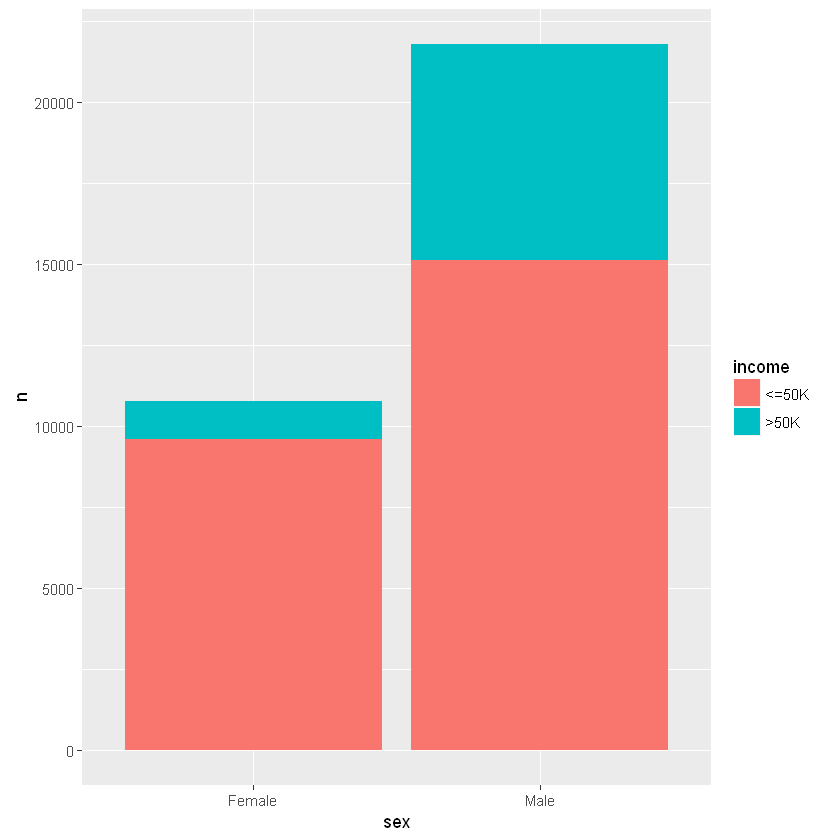

In [8]:
ggplot((income_count_sex), aes(x = sex, y = n, fill = income)) +
  geom_bar(stat = "identity") 
   

## From the bar blot, it can be seen that higher proportion of women has income less than 50K
  

In [9]:
## Similarly, let's explore the variable "workclass", which means , in which kind of industry respondendants are employed
table(train_data$workclass)

## we can see that some categories are small categories, hence, they can be combined. Combining the rare levels helps
## to avoid redundannt levels. SO, "Never-worked" and "without -pay" are combined into one group called "other".



train_data$workclass = gsub('^Never-worked', 'Other', train_data$workclass)
train_data$workclass = gsub('^Without-pay', 'Other', train_data$workclass)


test_data$workclass = gsub('^Never-worked', 'Other', test_data$workclass)
test_data$workclass = gsub('^Without-pay', 'Other', test_data$workclass)



     Federal-gov        Local-gov     Never-worked          Private 
             960             2093                7            22696 
    Self-emp-inc Self-emp-not-inc        State-gov      Without-pay 
            1116             2541             1298               14 

In [10]:
##Similarly, selfSelf-emp-inc and Self-emp-not-inc can be combined into one group, self-employed

train_data$workclass = gsub('^Self-emp-not-inc', 'self-employeded', train_data$workclass)
train_data$workclass = gsub('^Self-emp-inc', 'self-employeded', train_data$workclass)


test_data$workclass = gsub('^Self-emp-not-inc', 'self-employeded', test_data$workclass)
test_data$workclass = gsub('^Self-emp-inc', 'self-employeded', test_data$workclass)

test_data$workclass=as.factor(test_data$workclass)
train_data$workclass=as.factor(train_data$workclass)

income_count_workclass = count(train_data, workclass , income)

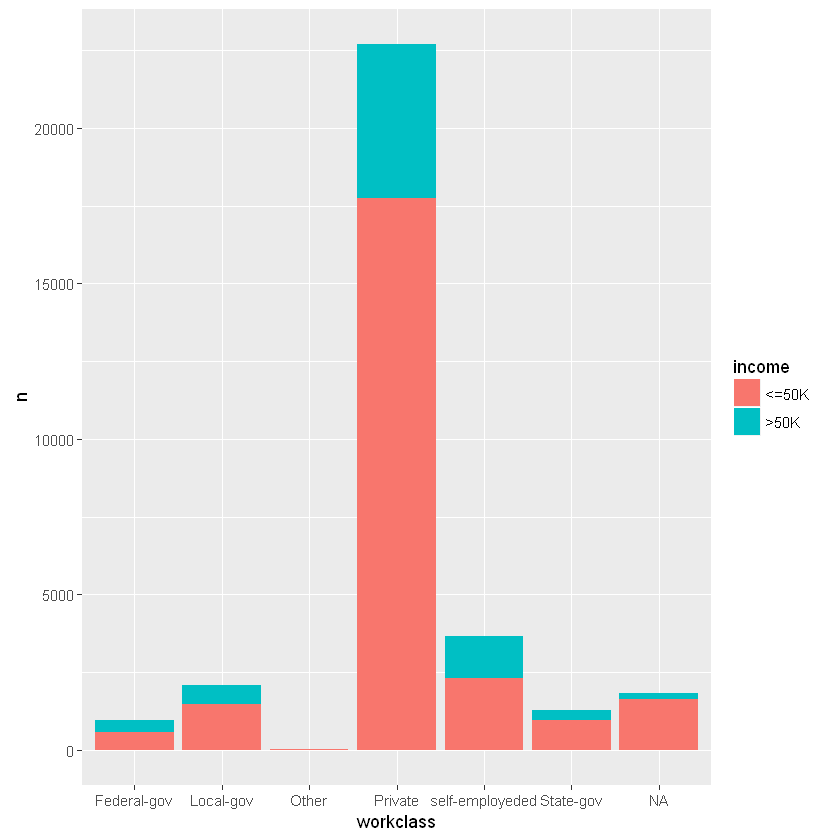

In [11]:


ggplot((income_count_workclass), aes(x = workclass, y = n, fill = income)) +
  geom_bar(stat = "identity") 

In [12]:
table(train_data$occupation)


     Adm-clerical      Armed-Forces      Craft-repair   Exec-managerial 
             3770                 9              4099              4066 
  Farming-fishing Handlers-cleaners Machine-op-inspct     Other-service 
              994              1370              2002              3295 
  Priv-house-serv    Prof-specialty   Protective-serv             Sales 
              149              4140               649              3650 
     Tech-support  Transport-moving 
              928              1597 

In [13]:
table(train_data$relationship)



       Husband  Not-in-family Other-relative      Own-child      Unmarried 
         13193           8305            981           5068           3446 
          Wife 
          1568 

In [14]:
table(train_data$marital_status)
## Similarlry, we can reduce the categories for marital_status variable, making single married level.


             Divorced     Married-AF-spouse    Married-civ-spouse 
                 4443                    23                 14976 
Married-spouse-absent         Never-married             Separated 
                  418                 10683                  1025 
              Widowed 
                  993 

In [15]:
 train_data$marital_status = gsub("^Married-AF-spouse", "Married" , train_data$marital_status)
train_data$marital_status = gsub("^Married-spouse-absent", "Married" , train_data$marital_status)
train_data$marital_status = gsub("^Married-civ-spouse", "Married" , train_data$marital_status)
#train_data$marital_status[train_data$marital_status == "Married-AF-spouse"]= "Married"

## FOr test data

test_data$marital_status = gsub("^Married-AF-spouse", "Married" , test_data$marital_status)
test_data$marital_status = gsub("^Married-spouse-absent", "Married" , test_data$marital_status)
test_data$marital_status = gsub("^Married-civ-spouse", "Married" , test_data$marital_status)


test_data$marital_status= as.factor(test_data$marital_status)
train_data$marital_status= as.factor(train_data$marital_status)

In [16]:
#train_data$marital_status = as.factor(train_data$marital_status)
table(train_data$marital_status)


     Divorced       Married Never-married     Separated       Widowed 
         4443         15417         10683          1025           993 

In [17]:
income_count_marital_status = count(train_data, marital_status , income)
income_count_marital_status

,marital_status,income,n
1,Divorced,<=50K,3980
2,Divorced,>50K,463
3,Married,<=50K,8681
4,Married,>50K,6736
5,Never-married,<=50K,10192
6,Never-married,>50K,491
7,Separated,<=50K,959
8,Separated,>50K,66
9,Widowed,<=50K,908
10,Widowed,>50K,85


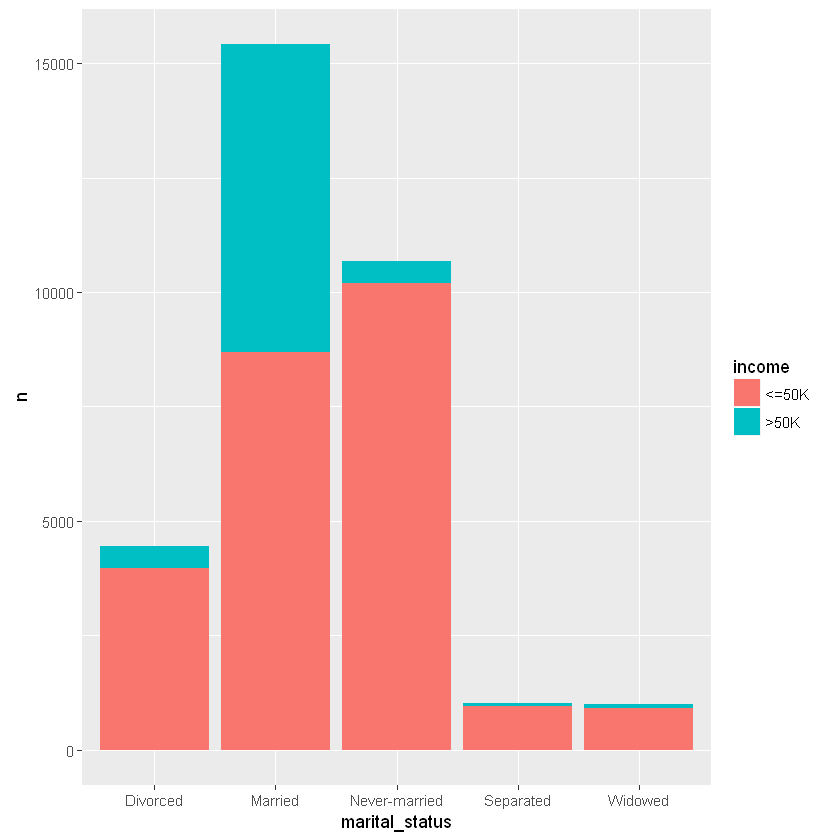

In [18]:
ggplot((income_count_marital_status), aes(x = marital_status, y = n, fill = income)) +
  geom_bar(stat = "identity") 

## Bar plot shows that higher proportion of married people have  having income more than 50K


In [19]:
prop.table(table(train_data$native_country))## Looking at this variable, it can be seen that almost 90% of data belongs to United states only.
##SO, we can discard as it is highly skewed.

train_data$native_country= NULL
test_data$native_country= NULL


                  Cambodia                     Canada 
              0.0005941585               0.0037838514 
                     China                   Columbia 
              0.0023453624               0.0018450185 
                      Cuba         Dominican-Republic 
              0.0029707924               0.0021890049 
                   Ecuador                El-Salvador 
              0.0008756020               0.0033147789 
                   England                     France 
              0.0028144349               0.0009068735 
                   Germany                     Greece 
              0.0042841954               0.0009068735 
                 Guatemala                      Haiti 
              0.0020013759               0.0013759460 
        Holand-Netherlands                   Honduras 
              0.0000312715               0.0004065295 
                      Hong                    Hungary 
              0.0006254300               0.0004065295 
         

Amer-Indian-Eskimo Asian-Pac-Islander              Black              Other 
               311               1039               3124                271 
             White 
             27816

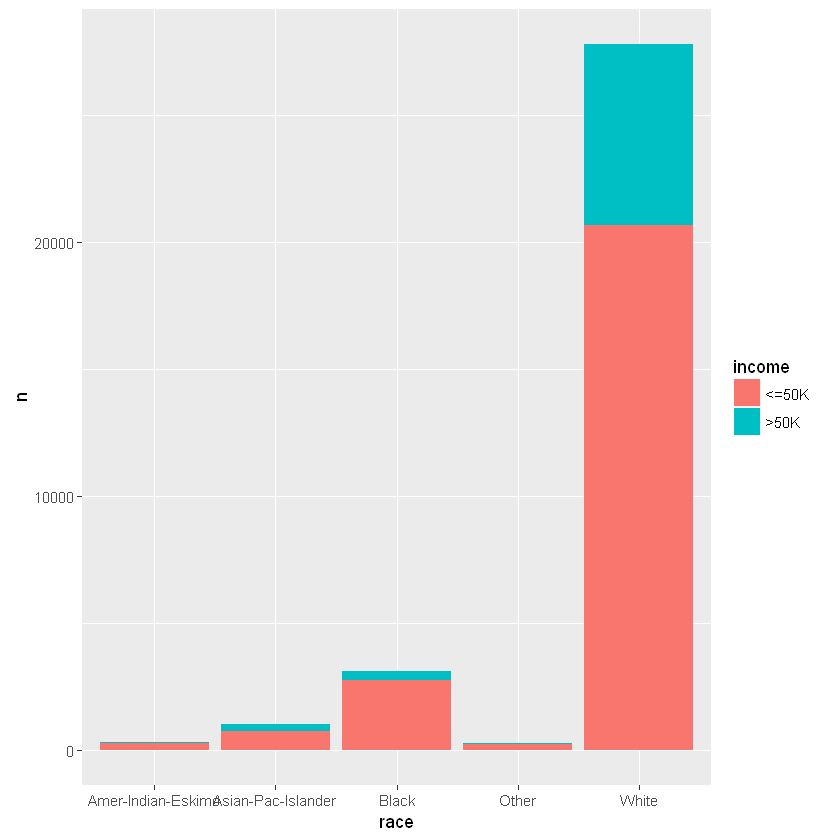

In [20]:

train_data$race= as.factor(train_data$race)
summary(train_data$race)

## As can be seen the majority of respondents are white.

income_count_race = count(train_data, race , income)

ggplot((income_count_race), aes(x = race, y = n, fill = income)) +
  geom_bar(stat = "identity") 

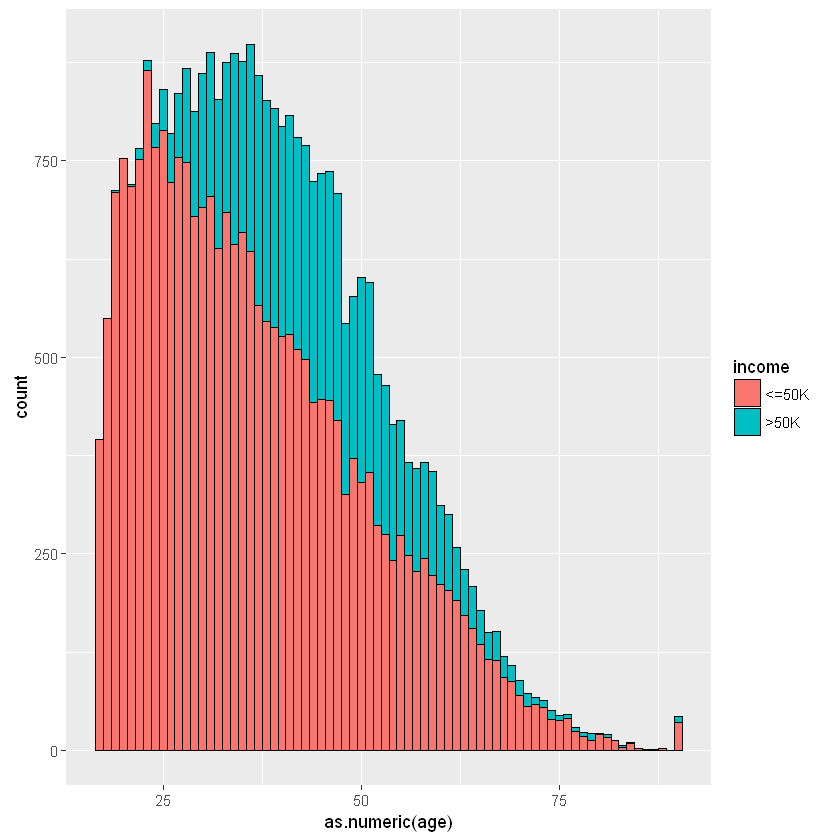

In [21]:
## Let's beging plotting histogram of variable age by income group

ggplot(train_data) + aes(x=as.numeric(age), group=income, fill=income) + 
  geom_histogram(binwidth=1, color='black')

## Histogram shows the more people  at the middle of their carrier has income more than 50K

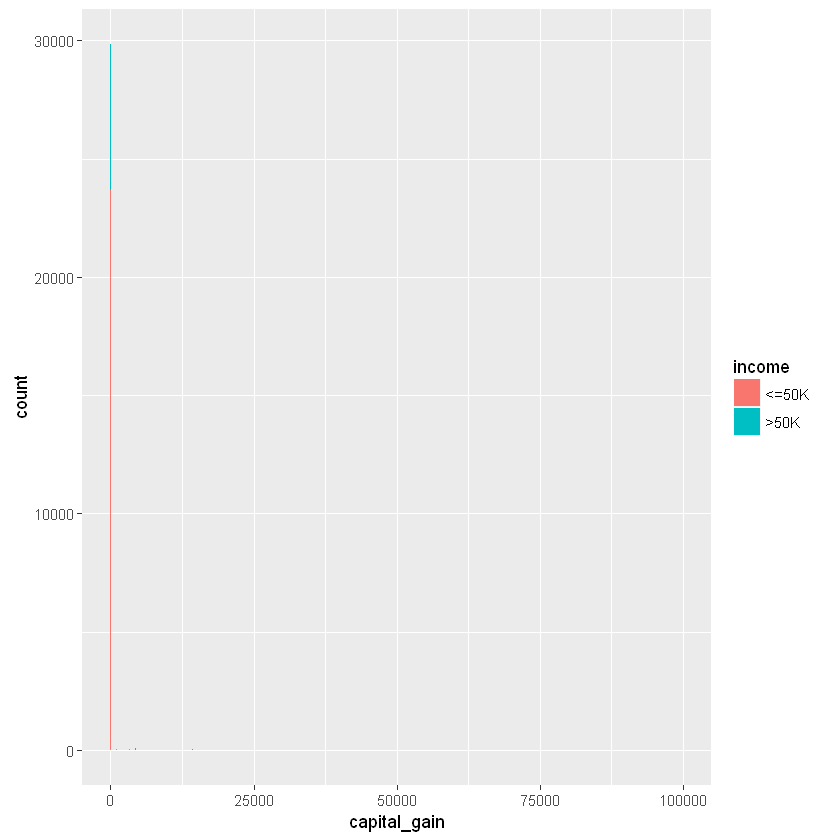

In [7]:
## Histogram for capital gain 
ggplot(train_data) + aes(x = capital_gain, group=income, fill=income) + 
  geom_histogram(binwidth=20)

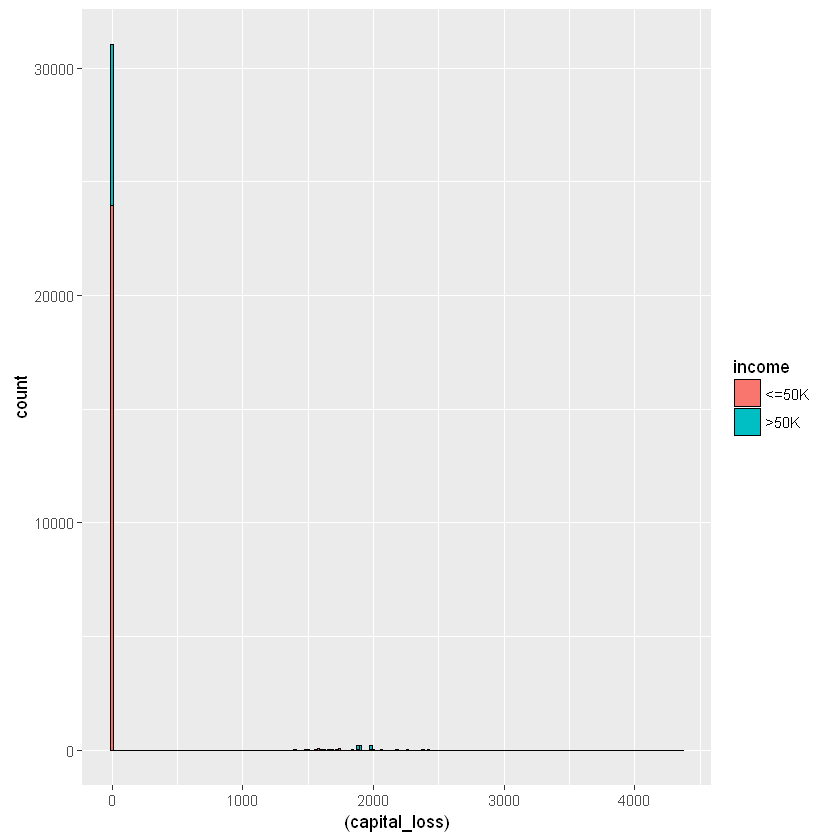

In [23]:
## Histogram for capital loss 
ggplot(train_data) + aes(x=(capital_loss), group=income, fill=income) + 
  geom_histogram(binwidth=20, color='black')

In [24]:
## Both the capital gain and capital loss histogram shows that, they both are highly skewed, mostly concentrated around zero. 
## So, we can drop these two variables too

train_data$capital_gain = NULL
train_data$capital_loss = NULL

test_data$capital_gain = NULL
test_data$capital_loss = NULL


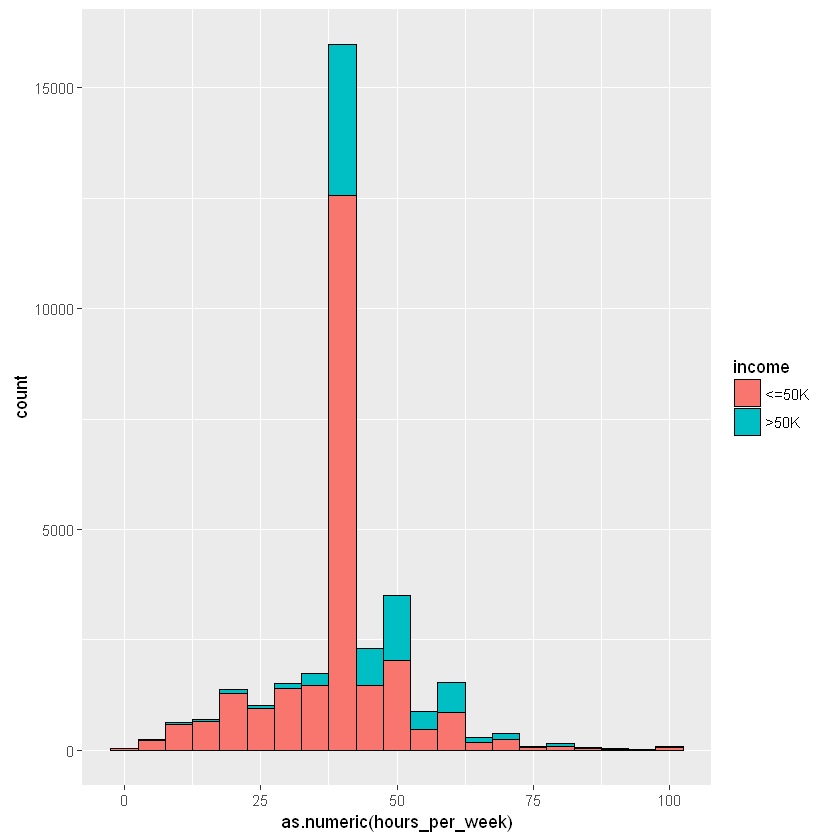

In [25]:
## Histogram for hours_per_week
ggplot(train_data) + aes(x=as.numeric(hours_per_week), group=income, fill=income) + 
  geom_histogram(binwidth=5, color='black')

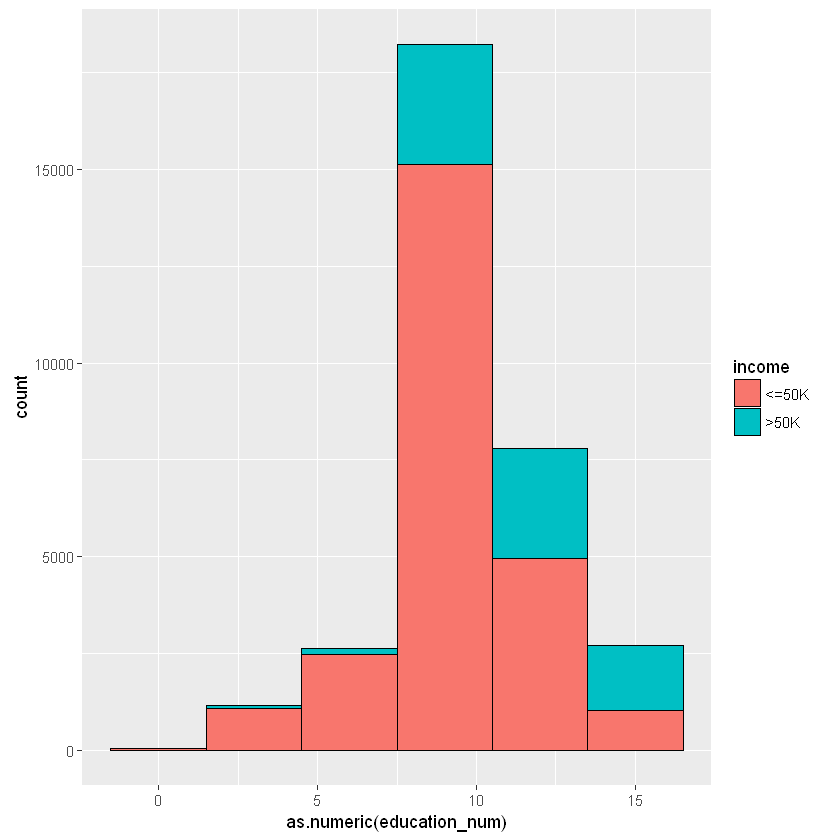

In [26]:
## Histogram for number of education
ggplot(train_data) + aes(x=as.numeric(education_num), group=income, fill=income) + 
  geom_histogram(binwidth=3, color='black')

## Histogram shows people with high  number of years of education, have income more than 50K.

In [27]:
### Now removing na's 
complete_indices_train= complete.cases(train_data)
complete_indices_test=complete.cases(test_data)


train_data=train_data[complete_indices_train, ]
test_data=test_data[complete_indices_test, ]

dim(train_data)
dim(test_data)


[1] 30718    10

[1] 15315    10

In [28]:
##  now encoding the class labels
train_data[,"income"] = ifelse(train_data[, "income"]== "<=50K",0,1)
test_data[,"income" ] = ifelse(test_data[, "income"] == "<=50K.",0,1)


train_data[,"income"]=as.factor(train_data[,"income"])
test_data[,"income" ]=as.factor(test_data[,"income" ])

In [29]:
###############  viewing the class distribution 

table(train_data[,"income"] )
table(test_data[,"income"] )



    0     1 
23068  7650 


    0     1 
11543  3772 

In [30]:
summary(train_data)

summary(test_data)

      age                  workclass     education_num         marital_status 
 Min.   :17.00   Federal-gov    :  960   Min.   : 1.00   Divorced     : 4258  
 1st Qu.:28.00   Local-gov      : 2093   1st Qu.: 9.00   Married      :14749  
 Median :37.00   Other          :   14   Median :10.00   Never-married: 9912  
 Mean   :38.44   Private        :22696   Mean   :10.13   Separated    :  959  
 3rd Qu.:47.00   self-employeded: 3657   3rd Qu.:13.00   Widowed      :  840  
 Max.   :90.00   State-gov      : 1298   Max.   :16.00                        
                                                                              
           occupation           relationship                   race      
 Prof-specialty :4140   Husband       :12704   Amer-Indian-Eskimo:  286  
 Craft-repair   :4099   Not-in-family : 7865   Asian-Pac-Islander:  974  
 Exec-managerial:4066   Other-relative:  918   Black             : 2909  
 Adm-clerical   :3770   Own-child     : 4525   Other             :  248 

      age                  workclass     education_num         marital_status
 Min.   :17.00   Federal-gov    :  472   Min.   : 1.00   Divorced     :2105  
 1st Qu.:28.00   Local-gov      : 1043   1st Qu.: 9.00   Married      :7317  
 Median :37.00   Other          :    7   Median :10.00   Never-married:4963  
 Mean   :38.78   Private        :11210   Mean   :10.13   Separated    : 474  
 3rd Qu.:48.00   self-employeded: 1900   3rd Qu.:13.00   Widowed      : 456  
 Max.   :90.00   State-gov      :  683   Max.   :16.00                       
                                                                             
           occupation           relationship                  race      
 Prof-specialty :2032   Husband       :6301   Amer-Indian-Eskimo:  149  
 Exec-managerial:2020   Not-in-family :4051   Asian-Pac-Islander:  449  
 Craft-repair   :2013   Other-relative: 482   Black             : 1447  
 Sales          :1854   Own-child     :2181   Other             :  127  
 Adm-cleric

In [31]:
## Prediciting using random forest 

rf_model= randomForest(train_data[, -10], as.factor(train_data[,10]),proximity = F, ntree= 501)

In [32]:
rf_predict=predict(rf_model, test_data[,-10])


In [38]:
confusion_matrix_rf= confusionMatrix( rf_predict , test_data[,10],)
print(confusion_matrix_rf$table)

confusion_matrix_rf$byClass

## It can be seen that overall accuracy of random forest model is around 83 percent. However, if we closely see the confusion 
##matrix, we can see that class which has higher representation in traning set is classified more accurately than class which
## has lower representation in traning set. Almost 90 % percent of majority class are correctly classfied but only around 59 % 
# of minority class are correcly classified

          Reference
Prediction     0     1
         0 10463  1554
         1  1080  2218


Sensitivity          Specificity       Pos Pred Value 
           0.9064368            0.5880170            0.8706832 
      Neg Pred Value           Prevalence       Detection Rate 
           0.6725288            0.7537055            0.6831864 
Detection Prevalence    Balanced Accuracy 
           0.7846556            0.7472269

In [39]:
sum(diag(confusion_matrix_rf$table))/sum(confusion_matrix_rf$table) 


[1] 0.8280118

In [40]:
## xgboost model

In [41]:
## Since, xgboost accept only numerical variable, we first need to convert categorical variable into numeric 
encoder= dummyVars(" ~ .", data = train_data[, -10],fullRank = T)
train_encoded = data.frame(predict(encoder, newdata = train_data[, -10]))
test_encoded =data.frame(predict(encoder, newdata = test_data[, -10] ))

train_label=train_data[, 10]
test_label=test_data[, 10]     ## Separating the target variable, both for train and test data






In [42]:
#  putting  testing & training data into two seperates Dmatrixs objects


dtrain =  xgb.DMatrix(data = as.matrix(train_encoded), label= as.numeric(as.character(train_label)))
dtest = xgb.DMatrix(data = as.matrix(test_encoded), label= as.numeric(as.character(test_label)))

In [43]:
params = list(booster = "gbtree", objective = "binary:logistic", eta=0.3, gamma=0, max_depth=8, min_child_weight=1, 
              subsample=1, colsample_bytree=.7)

xgbcv = xgb.cv( params = params, data = dtrain, nrounds = 40, nfold = 5, showsd = T, stratified = T, 
               print.every.n = 10,  maximize = F, metric="error")



 

[0]	train-error:0.170324+0.004759	test-error:0.180155+0.007884
[10]	train-error:0.151312+0.001364	test-error:0.165115+0.004573
[20]	train-error:0.145705+0.001788	test-error:0.165603+0.003850
[30]	train-error:0.141033+0.002422	test-error:0.165603+0.004701


In [44]:

xg_model  =  xgboost(data = dtrain, # the data           
                 max.depth = 6, # the maximum depth of each decision tree
                 nround = 40, # max number of boosting iterations
                 objective = "binary:logistic",
                    eval_metric = "error",
                    eta=0.5,
                     silent=0,
                     
                     
                     
                     )
pred_xgboost =  predict(xg_model, dtest)



[0]	train-error:0.173514
[1]	train-error:0.171821
[2]	train-error:0.166547
[3]	train-error:0.164854
[4]	train-error:0.162380
[5]	train-error:0.160981
[6]	train-error:0.160167
[7]	train-error:0.159288
[8]	train-error:0.158734
[9]	train-error:0.157920
[10]	train-error:0.156618
[11]	train-error:0.156423
[12]	train-error:0.154828
[13]	train-error:0.154502
[14]	train-error:0.154405
[15]	train-error:0.153819
[16]	train-error:0.152386
[17]	train-error:0.152516
[18]	train-error:0.151703
[19]	train-error:0.151214
[20]	train-error:0.150986
[21]	train-error:0.150303
[22]	train-error:0.148642
[23]	train-error:0.147894
[24]	train-error:0.147503
[25]	train-error:0.147145
[26]	train-error:0.146852
[27]	train-error:0.145940
[28]	train-error:0.145940
[29]	train-error:0.146038
[30]	train-error:0.146071
[31]	train-error:0.146136
[32]	train-error:0.145387
[33]	train-error:0.143922
[34]	train-error:0.143304
[35]	train-error:0.143076
[36]	train-error:0.143076
[37]	train-error:0.142490
[38]	train-error:0.142

In [47]:
prediction_xgboost = as.factor (as.numeric(pred_xgboost > 0.5))
confusion_matrix_xgboost= confusionMatrix(prediction_xgboost, test_data[, 10] )
confusion_matrix_xgboost$table

confusion_matrix_xgboost$byClass

sum(diag(confusion_matrix_xgboost$table))/sum(confusion_matrix_xgboost$table)

          Reference
Prediction     0     1
         0 10508  1528
         1  1035  2244

Sensitivity          Specificity       Pos Pred Value 
           0.9103353            0.5949099            0.8730475 
      Neg Pred Value           Prevalence       Detection Rate 
           0.6843550            0.7537055            0.6861247 
Detection Prevalence    Balanced Accuracy 
           0.7858962            0.7526226

[1] 0.8326477

In [1]:
## If we comapre the performance  of random forest model and xgboost model, xgboost performace is slightly better than
## random forest, both in terms of overall accuracy, and predicting minority class.

## 

In [48]:

tasks = makeClassifTask(data = train_data,target = "income")

sampled_train=smote(tasks, rate=2, nn = 5L,  alt.logic = FALSE)

sampled_train=(getTaskData(sampled_train))

In [49]:

print( table(train_data[,"income"] ))
print(paste("class distribution before data sampling"))

print(table(sampled_train[,10]))
print (paste("class distribution after data sampling"))

## We see now, the number of minority class has been doubled in newly sampled training set.


    0     1 
23068  7650 
[1] "class distribution before data sampling"

    0     1 
23068 15300 
[1] "class distribution after data sampling"


In [50]:
rf_model_sampled= randomForest(sampled_train[, -10], as.factor(sampled_train[,10]),proximity = F, ntree= 501)

In [51]:
rf_predict_sampled = predict(rf_model_sampled, test_data[,-10])
confusion_matrix_rf_sampled= confusionMatrix( rf_predict_sampled , test_data[,10],)
confusion_matrix_rf_sampled$table
confusion_matrix_rf_sampled$byClass


## We didn't see the significant improve in minority class prediciton after sampling of data too


          Reference
Prediction     0     1
         0 10386  1496
         1  1157  2276

Sensitivity          Specificity       Pos Pred Value 
           0.8997661            0.6033934            0.8740953 
      Neg Pred Value           Prevalence       Detection Rate 
           0.6629770            0.7537055            0.6781587 
Detection Prevalence    Balanced Accuracy 
           0.7758407            0.7515798

In [78]:
sum(diag(confusion_matrix_rf_sampled$table))/sum(confusion_matrix_rf_sampled$table) 

[1] 0.8268364

In [52]:
encoder_sampled= dummyVars(" ~ .", data = sampled_train[, -10],fullRank = T)
train_sampled_encoded = data.frame(predict(encoder_sampled, newdata = sampled_train[, -10]))
test_sampled_encoded =data.frame(predict(encoder_sampled, newdata = test_data[, -10] ))


dtrain_sampled =  xgb.DMatrix(data = as.matrix(train_sampled_encoded), label= as.numeric(as.character(sampled_train[, 10])))
dtest_sampled= xgb.DMatrix(data = as.matrix(test_sampled_encoded), label= as.numeric(as.character(test_data[, 10])))

In [53]:
xg_model_sampled  =  xgboost(data = dtrain_sampled, # the data           
                 max.depth = 6, # the maximum depth of each decision tree
                 nround = 40, # max number of boosting iterations
                 objective = "binary:logistic",
                    eval_metric = "error",
                    eta=0.5,
                     silent=0,
                     
                     
                     
                     )
pred_xgboost_sampled =  predict(xg_model_sampled,dtest_sampled)



[0]	train-error:0.163574
[1]	train-error:0.158127
[2]	train-error:0.154165
[3]	train-error:0.152314
[4]	train-error:0.150568
[5]	train-error:0.148275
[6]	train-error:0.146607
[7]	train-error:0.146111
[8]	train-error:0.144860
[9]	train-error:0.139804
[10]	train-error:0.140247
[11]	train-error:0.138344
[12]	train-error:0.137797
[13]	train-error:0.136598
[14]	train-error:0.134487
[15]	train-error:0.133862
[16]	train-error:0.133757
[17]	train-error:0.133392
[18]	train-error:0.132220
[19]	train-error:0.132037
[20]	train-error:0.131359
[21]	train-error:0.131099
[22]	train-error:0.130421
[23]	train-error:0.129874
[24]	train-error:0.129118
[25]	train-error:0.127632
[26]	train-error:0.126486
[27]	train-error:0.126486
[28]	train-error:0.125756
[29]	train-error:0.125912
[30]	train-error:0.125808
[31]	train-error:0.125026
[32]	train-error:0.124609
[33]	train-error:0.124036
[34]	train-error:0.123723
[35]	train-error:0.123410
[36]	train-error:0.122576
[37]	train-error:0.122055
[38]	train-error:0.121

In [55]:
prediction_xgboost_sampled = as.factor (as.numeric(pred_xgboost_sampled > 0.5))
confusion_matrix_xgboost_sampled= confusionMatrix(prediction_xgboost_sampled,test_data[, 10] )
confusion_matrix_xgboost_sampled$table
confusion_matrix_xgboost_sampled$byClass

sum(diag(confusion_matrix_xgboost_sampled$table))/sum(confusion_matrix_xgboost_sampled$table)

          Reference
Prediction     0     1
         0 10379  1432
         1  1164  2340

Sensitivity          Specificity       Pos Pred Value 
           0.8991597            0.6203606            0.8787571 
      Neg Pred Value           Prevalence       Detection Rate 
           0.6678082            0.7537055            0.6777016 
Detection Prevalence    Balanced Accuracy 
           0.7712047            0.7597601

[1] 0.830493

 num [1:15315] 0.0048 0.404 0.4468 0.3306 0.0114 ...


In [88]:
## Now we change the cutoff probability balue.. Until now, we have been using 0.5 probability

xgbpred_cuttoff = ifelse (pred_xgboost_sampled > 0.4,1,0)

confu_mat_xgboost_sampled_cut= confusionMatrix(xgbpred_cuttoff,test_data[, 10] )

confu_mat_xgboost_sampled_cut$byClass

## We now see the changing the cut off values gave much better prediction accuracy for minority class than at 0.5 cutoff value.

Sensitivity          Specificity       Pos Pred Value 
           0.8493459            0.7184517            0.9022639 
      Neg Pred Value           Prevalence       Detection Rate 
           0.6091256            0.7537055            0.6401567 
Detection Prevalence    Balanced Accuracy 
           0.7095005            0.7838988